# Predict The News Category

In [2]:
!pip install tensorflow
!pip install wget

  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19558 sha256=9bb374896ccf405ef3c0385131d0b285fd5df9ef3d4103f497f9fc52bb8be4e2
  Stored in directory: c:\users\tlgus\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=28eac5c95c4d166c26758e12d36cd0f8498ffecd5b85deea9d16c75b537b4b83
  Stored in directory: c:\users\tlgus\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built wrapt termcolor
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
      Successfully uninstalled wrapt-1.11.2
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0


분석에 앞서 필요한 모듈을 불러온다.

In [85]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import wget
import zipfile

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding
import seaborn as sns
from collections import Counter

### load dataset

본 분석은 MachineHack 사이트에서 개최하는 'Predict The News Category Hackathon' 공모전 데이터를 다룬다.

https://machinehack.com/hackathons/predict_the_news_category_hackathon

In [2]:
train = pd.read_excel('Data_Train.xlsx')
test = pd.read_excel('Data_Test.xlsx')

submission = pd.read_excel('Sample_submission.xlsx')

train set의 구성은 아래와 같다.
* STORY(X) : 기사 전문
* SECTION(Y) : 기사의 카테고리

In [3]:
train.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


SECTION은 총 네 개의 카테고리로 나뉘어있다. 즉, 본 분석은 multi class classification에 해당한다.

In [4]:
print("We have a total of {} categories".format(train['SECTION'].nunique()))

train['SECTION'].value_counts()

We have a total of 4 categories


1    2772
2    1924
0    1686
3    1246
Name: SECTION, dtype: int64

### train set quality check

데이터 전처리에 앞서 train set에 중복값, 결측값이 있는지 확인한다. 해당 작업을 거치면 학습을 더욱 용이하게 하고, 성능 향상도 기대할 수 있다.

* 중복된 observation 77개 제거
* 결측 observation은 없는 것으로 확인되었다.

In [5]:
print(train.duplicated().sum())

train = train.drop_duplicates(keep='last')

77


In [6]:
train.isnull().sum()

STORY      0
SECTION    0
dtype: int64

독립변수(기사)의 길이가 10자 내외로 유난히 짧은 경우, 분석에 방해가 되는 observation이 될 수 있으므로 제거할 목적으로 독립변수의 길이를 확인하였다.

확인 결과, minimum 길이가 100자로 low quality 기사는 없는 것으로 판단하였다.

In [7]:
train.STORY.str.len().describe()

count    7551.000000
mean      653.703351
std       522.284160
min       100.000000
25%       316.000000
50%       537.000000
75%       836.000000
max      6015.000000
Name: STORY, dtype: float64

In [20]:
for i in train.STORY :
    if len(i)==100 : print(i)

Having the chance to reimagine Pinhead and the Cenobites for a new audience is a nightmare-come-true
The movie is led by Margot Robbie’s Harley Quinn, who was the Joker’s love-interest in Suicide Squad
(But) things have changed today in terms of action, there is technology to help you,” Sunny told PTI
According to sources, it had 17 crore footfalls and had earned Rs 256 crore upon its release in 2001
It’s hard to remember who any of the cast members were 10 years ago,” Harington told People magazine
The actor said, “A person like me who has never had patience, this is God’s way to teach me patience
The directorial debut of Prithviraj Sukumaran set the box office on fire when it released last month


### data shuffling

train set 내에 특정 SECTION이 몰려있을 수 있기 때문에 shuffling을 진행한다.

In [8]:
train = shuffle(train)

### data tokenizing and padding

데이터셋을 모델에 input할 수 있는 형태를 만들어준다.

제공된 train set을 train/valid set으로 나눠준다. 비율은 0.2로 한다.

In [9]:
X, Y = train.STORY, train.SECTION

train_x, valid_x, train_y, valid_y = train_test_split(X, Y, test_size=0.2, random_state=79)

In [10]:
vocab_size = 30000
max_length = 500
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

tokenizer 옵션은 아래와 같이 설정한다.
* num_words = vocab_size = 30000 : STORY 내 빈도수 기준 30,000개의 단어를 토큰화한다.
* oov_token = oov_tok = '\<OOV\>' : out-of-vocabulary words를 '\<OOV\>'로 대체하여 표시한다.

In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size,
                                                  oov_token = oov_tok)
tokenizer.fit_on_texts(train_x)

train set 토큰화 결과이다. 빈도수 기준 10개 단어를 출력한 결과는 아래와 같다.

In [29]:
word_index = tokenizer.word_index

for key, value in word_index.items() :
    if value in range(1,10) : print(key)

<OOV>
the
to
of
and
in
a
is
on


train set을 모델에 input할 수 있도록 sequence로 변환한다.

* texts_to_sequences(x) : train set의 STORY 기사 전문 텍스트 각 단어를 상응하는 숫자로 바꿔준다.

* pad_sequences(x) : 모델에 input하기 전, 각 기사 시퀀스의 길이를 맞추는 작업을 진행한다.
  - maxlen = max_length = 500 : 모든 기사의 길이를 최대 500으로 맞춘다. (median=537 값을 참고하였다.)
  - padding = padding_type = 'post' : 500자 이하의 기사 경우, 뒷부분 빈 공간을 0으로 채운다.
  - truncating = trunc_type = 'post' : 500자 이상의 기사인 경우, 뒷부분 초과된 시퀀스를 지운다.
  
* get_dummies(y) : 예를 들어, [1,2]의 형태를 [[1,0],[0,1]]의 형태로 바꿔준다. (for multi class classification)


train set으로 피팅한 tokenizer를 train/valid set 모두에 적용한 뒤, 각 시퀀스를 np.array로 바꿔준다.

In [12]:
def get_sequences(x, y):
    x = tokenizer.texts_to_sequences(x)
    x = pad_sequences(x, maxlen = max_length, padding = padding_type, truncating = trunc_type)
    y = np.asarray(y)
    y = pd.get_dummies(y)
    
    x = np.array(x) ; y = np.array(y)
    return x, y

train_x, train_y = get_sequences(train_x, train_y)
valid_x, valid_y = get_sequences(valid_x, valid_y)

y의 shape의 경우, SECTION이 총 네 개였기 때문에 (n, 4)가 된다.

In [13]:
print(train_x.shape)
print(train_y.shape)

print(valid_x.shape)
print(valid_y.shape)

(6040, 500)
(6040, 4)
(1511, 500)
(1511, 4)


### embedding matrix - GloVe

pretrained word embeddings인 GloVe를 사용한다. 여러 버전 중, 400,000개의 단어를 200차원으로 표현한 파일을 다운로드받아 사용한다.

In [57]:
wget.download('http://nlp.stanford.edu/data/glove.6B.zip')

100% [......................................................................] 862182613 / 862182613

'glove.6B.zip'

In [14]:
zipfile.ZipFile('glove.6B.zip').extractall()

In [32]:
len(tokenizer.word_index.items())

34622

In [37]:
path_to_glove_file = './glove.6B.200d.txt'
num_tokens = len(tokenizer.word_index.items())
embedding_dim = 200
hits = 0
misses = 0

embedding matrix 생성 관련 함수 설명은 코드 내 주석 참고하면 된다.

In [38]:
embeddings_index = {}

with open(path_to_glove_file, encoding='UTF8') as f :
    for line in f :
        # glove.6B.200d.txt 파일은 word coef1 coef2 .. coef200 형식으로 되어있으므로 첫번째 separator로 split하여 word, coefs 구분
        word, coefs = line.split(maxsplit=1)
        # 각 coefs들을 separator 기준으로 각각의 coef로 쪼갠다.
        coefs = np.fromstring(coefs, 'f', sep=' ')
        # embeddings_index 딕셔너리에 word, coefs를 각각 key, value로 추가한다.
        embeddings_index[word] = coefs
        
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [39]:
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in tokenizer.word_index.items() :
    # train set 내 word에 대응하는 coefs vector를 가져온다.
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None :
        # train set 내 word가 embedding index 딕셔너리(from GloVe)에 존재하는 경우, embedding_matrix에 추가한다.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else :
        # train set 내 word가 embedding index 딕셔너리(from GloVe)에 존재하지 않는 경우, 0벡터로 남는다.
        misses += 1
        
print('Converted %d words (%d misses)' % (hits, misses))

Converted 25534 words (9088 misses)


embedding matrix 생성 결과, 트레인셋 내 총 25534개의 단어의 coefs vector를 embedding_matrix에 추가할 수 있었다.

### baseline model

우선 캐글의 비슷한 주제 competition을 찾아, 참고 코드를 baseline model로 활용하였다.

https://www.kaggle.com/derinrobert/newsclassification-using-lstm

In [17]:
# epoch이 진행됨에 따라 loss가 0.0001만큼의 변동이 3번 이상이면 더이상 훈련하지 않고 멈춘다.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

tf.keras.backend.clear_session()
embed_size = 200

model = keras.models.Sequential([
    Embedding(num_tokens,
              embedding_dim,
              # 위에서 생성한 pretrained embedding matrix
              embeddings_initializer = keras.initializers.Constant(embedding_matrix),
              # not result in returning a zero vector
              mask_zero = True,
              input_shape = [None],
              # 아래 dense layer만 훈련
              trainable = False),
    keras.layers.Bidirectional(keras.layers.LSTM(256, dropout=0.4)),
    keras.layers.Dense(4, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         6924800   
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               935936    
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
Total params: 7,862,788
Trainable params: 937,988
Non-trainable params: 6,924,800
_________________________________________________________________


In [42]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

# batch size 32, epoch 10으로 설정하여 훈련시킨다.
history = model.fit(train_x, train_y,
                    batch_size = 32,
                    validation_data = (valid_x, valid_y),
                    epochs = 10,
                    callbacks = early_stop)

Epoch 1/10
189/189 [==============================] - 2435s 13s/step - loss: 0.3582 - accuracy: 0.8760 - val_loss: 0.2879 - val_accuracy: 0.9199
Epoch 2/10
189/189 [==============================] - 2299s 12s/step - loss: 0.1954 - accuracy: 0.9391 - val_loss: 0.1846 - val_accuracy: 0.9471
Epoch 3/10
189/189 [==============================] - 2610s 14s/step - loss: 0.2804 - accuracy: 0.9076 - val_loss: 0.2149 - val_accuracy: 0.9345
Epoch 4/10
189/189 [==============================] - 1617s 9s/step - loss: 0.1460 - accuracy: 0.9525 - val_loss: 0.1329 - val_accuracy: 0.9590
Epoch 5/10
189/189 [==============================] - 1210s 6s/step - loss: 0.1165 - accuracy: 0.9623 - val_loss: 0.1712 - val_accuracy: 0.9497
Epoch 6/10
189/189 [==============================] - 1909s 10s/step - loss: 0.1012 - accuracy: 0.9682 - val_loss: 0.1374 - val_accuracy: 0.9596
Epoch 7/10
189/189 [==============================] - 2514s 13s/step - loss: 0.0820 - accuracy: 0.9743 - val_loss: 0.1052 - val_accu

훈련 결과, accuracy와 loss(cross entropy) 값을 비교했다.

과적합이 일어나지 않았고, validation set accuracy도 0.96을 웃돌 정도로 매우 높다. epoch을 더 늘려 훈련시키면 보다 높은 성능을 기대해볼 수 있겠다.

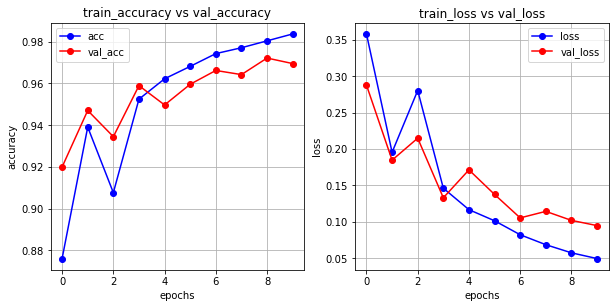

In [43]:
fig = plt.figure(figsize=(10,10))

# accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

### predict

kaggle에서 참고한 baseline 모델로 predict하여 성능을 확인한다.

In [44]:
classes = train.SECTION.value_counts().index

def prediction(inference_data):
    X = tokenizer.texts_to_sequences(inference_data)
    X = pad_sequences(X, maxlen= max_length, padding=padding_type, truncating=trunc_type)
    pred = model.predict(X)
    pred_value = tf.argmax(pred,axis =1).numpy()                
    return pred_value

In [45]:
test_x = test.STORY

y_pred = prediction(test_x)

In [92]:
submission.SECTION = y_pred

submission.to_csv('submission_baseline.csv', index=True)

### My model

baseline model에서는 bidirectional recurrent layer를 이용해 훈련시켰다.  
위 모델로도 뛰어난 성능을 보이지만, convolutional layer를 추가해 성능 향상을 시도하였다.

위 baseline model에서도 적은 hidden layers로도 높은 성능을 보였기 때문에,
my model에서도 layer를 깊게 쌓지 않았다.

In [103]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

tf.keras.backend.clear_session()
embed_size = 200

model = keras.models.Sequential([
    Embedding(num_tokens, embedding_dim, embeddings_initializer = keras.initializers.Constant(embedding_matrix),
              mask_zero = True, input_shape = [None], trainable = False),
    keras.layers.Conv1D(64, 10, activation='relu'),
    keras.layers.MaxPooling1D(10),
    keras.layers.Conv1D(32, 10, activation='relu'),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(4, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         6924400   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          128064    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          20512     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 7,073,108
Trainable params: 148,708
Non-trainable params: 6,924,400
________________________________________

In [106]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

# batch size 32, epoch 20으로 설정하여 훈련시킨다.
history = model.fit(train_x, train_y,
                    batch_size = 32,
                    validation_data = (valid_x, valid_y),
                    epochs = 20,
                    callbacks = early_stop)

Epoch 1/20
189/189 [==============================] - 26s 132ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.1657 - val_accuracy: 0.9636
Epoch 2/20
189/189 [==============================] - 25s 131ms/step - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.1619 - val_accuracy: 0.9616
Epoch 3/20
189/189 [==============================] - 25s 131ms/step - loss: 0.0264 - accuracy: 0.9916 - val_loss: 0.1657 - val_accuracy: 0.9590
Epoch 4/20
189/189 [==============================] - 25s 131ms/step - loss: 0.0303 - accuracy: 0.9916 - val_loss: 0.1707 - val_accuracy: 0.9576
Epoch 5/20
189/189 [==============================] - 25s 130ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 0.1813 - val_accuracy: 0.9643


early stopping rule에 따라 epoch=5에서 훈련이 종료되었으며,  
convolutional layer을 추가함에 따라 6시간 넘게 소요되었던 위 bidirectional RNN에 비해 3분도 안되는 시간 안에 높은 accuracy로 훈련이 종료되었다.

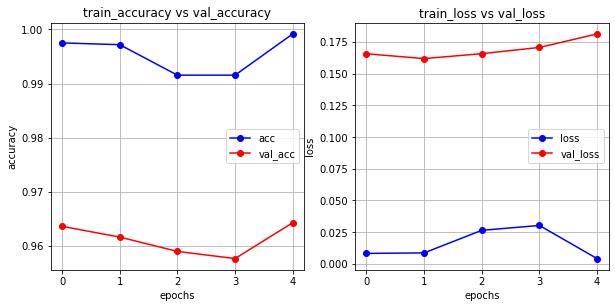

In [107]:
fig = plt.figure(figsize=(10,10))

# accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

### predict

My model로 predict하여 성능을 확인한다.

In [108]:
test_x = test.STORY

y_pred = prediction(test_x)

In [109]:
submission.SECTION = y_pred

submission.to_csv('submission_mymodel.csv', index=True)

classification이 잘 되었는지 각 SECTION 별로 기사 성향이 비슷한지 확인한다.

In [110]:
pred_set = pd.DataFrame({'STORY' : pd.Series(tokenizer.texts_to_sequences(test_x)),
                         'SECTION' : y_pred})

In [111]:
def get_freq_words(num, counter) :
    # 특정 SECTION에 대한 데이터프레임
    df_part = pred_set.loc[pred_set.SECTION==num, :].reset_index(drop=True)
    
    # 특정 SECTION 내 모든 단어(시퀀스 내 숫자)를 가져옴
    all_words = []
    for line in df_part.STORY : all_words += line
    
    # 각 단어의 개수를 세어, counter(e.g. 200)보다 많은 빈도만큼 나타난 단어(시퀀스 내 숫자)만 가져옴
    cnt = Counter(all_words)
    freq_num = []
    for key, value in cnt.items() :
        if value >= counter : freq_num.append(key)
    
    # tokenizer.word_index의 (word:number) 딕셔너리 자료를 이용해, 시퀀스 숫자에 상응하는 영단어를 가져옴
    freq_words = []
    for f in freq_num :
        for word, i in tokenizer.word_index.items() :
            if f==i : freq_words.append(word)
    
    print(freq_words)

꽤 비슷한 카테고리 별로 분류되었음을 확인할 수 있다.

In [112]:
get_freq_words(0, 200) # state, minister, elections, party, congress : 정치
get_freq_words(1, 200) # smartphones, technology, display, phone, camera, app, google, data, samsung, galaxy : IT 과학
get_freq_words(2, 100) # film, actor, avengers, movie : 연예, 예술
get_freq_words(3, 75) # shares, market, growth, dollar, prices, investors : 경제

['the', 'is', 'with', 'a', 'to', 'and', '<OOV>', 'said', 'that', 'in', 'this', 'have', 'it', 'state', 'of', 'he', 'minister', 'was', 'by', 'be', 'as', 'for', 'from', 'his', 'lok', 'sabha', 'on', 'has', 'not', 'who', 'are', 'elections', 'been', 'at', 'bjp', 'modi', 'party', 'an', 'congress', 'will', 'its', 'but']
['will', 'like', 'smartphones', 'and', 'the', 'to', 'a', 'new', 'india', '<OOV>', 'technology', 'in', 'have', 'an', 'of', 'with', 'on', 'be', 'or', 'year', 'we', 'can', 'are', 'from', 'they', 'up', 'display', 'phone', 'has', 'while', 'is', 'smartphone', 'said', 'it', 'apple', 'also', 'been', 'by', 'its', 'for', 'their', 'camera', 'note', '6', '2', '7', 'pro', 'you', 'out', 'more', 'that', 'at', 'one', 'this', 'but', 'as', 'not', 'about', 'app', 'which', 'google', 'was', 'would', 'company', 'data', 'redmi', 'all', 'than', 'users', '1', 'samsung', 'people', 'facebook', 'other', 'oneplus', 'galaxy']
['it', 'has', 'also', 'a', 'of', 'in', 'the', 'that', 'will', 'is', 'had', 'and', 

### result

test set 예측 결과를 공모전 사이트에 제출하여 스코어(accuracy)를 확인한 결과는 아래와 같다.

* baseline model : 0.96143
* my model : 0.96470

두 모델의 스코어는 비슷하지만, computing resource를 감안하였을 때 my model의 성능이 더 높다고 결론지을 수 있겠다.

* baseline model : 10 epochs, more than 6 hours
* my model : 5 epochs, less than 5 minutes